In [ ]:

try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

In [ ]:
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)

In [ ]:
# flatten 28*28 images to a 784 vector for each image  28*28 = 784
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

In [ ]:
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

In [ ]:
# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True) #shuffle 打乱数据
testloader = DataLoader(testset, batch_size=128, shuffle=True)

In [ ]:
# define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes): #input_size: 784 hidden_size: 784 num_classes 10
        super(BaselineModel, self).__init__() #必须有 调用父辈初始化函数

        # self.fc1 = nn.Linear(input_size, hidden_size) #784*784
        # self.fc2 = nn.Linear(hidden_size, num_classes)  #784*10

        self.fc1 = nn.Linear(input_size, hidden_size) #784*8
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)  #8*8
        self.fc4 = nn.Linear(hidden_size, num_classes) #8*10
     
    def forward(self, x): #前向传播 x是输入
        out = self.fc1(x)  #先进行一次线性
        out = F.relu(out)   #然后使用relu激活
        out = self.fc2(out)  #先进行一次线性
        out = F.relu(out)   #然后使用relu激活
        out = self.fc3(out)  #先进行一次线性
        out = F.relu(out)   #然后使用relu激活
        out = self.fc4(out)  #再进行一次线性
        # print('self:',self.training) #true
        if not self.training: #后面老师有解释
            out = F.softmax(out, dim=1)
        return out

In [ ]:
# model = BaselineModel(784, 15, 10) 
# print(model)

BaselineModel(
  (fc1): Linear(in_features=784, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=15, bias=True)
  (fc3): Linear(in_features=15, out_features=10, bias=True)
)


In [ ]:
import time
import scipy.integrate as integrate
import scipy
from scipy import io
start =time.time()

model = BaselineModel(784, 20, 10)  #(self, input_size, hidden_size, num_classes)

loss_function = nn.CrossEntropyLoss()
# optimiser = optim.Adam(model.parameters(),lr=0.001)  #根据loss-function去优化model = BaselineModel(784, 784, 10)
optimiser = optim.Adadelta(model.parameters())  #根据loss-function去优化model = BaselineModel(784, 784, 10)

f1_tmp = []
f2_tmp = []
f3_tmp = []
f4_tmp = []

b1_tmp = []
b2_tmp= []
b3_tmp = []
b4_tmp = []

loss_mse = []
for epoch in range(15):
    running_loss = 0.0

    for data in trainloader:
        # get the inputs
        inputs, labels = data #inputs[128,784] 一个epoch里面128个图片 一个图片784列 labels[128] 对应128个图片的标签

        optimiser.zero_grad()

        outputs = model(inputs) #inputs[128,784]
        
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        layer1 = model.fc1.state_dict()
        layer2 = model.fc2.state_dict()
        layer3 = model.fc3.state_dict()
        layer4 = model.fc4.state_dict()

        f1_tmp.append(np.array(layer1['weight']))
        f2_tmp.append(np.array(layer2['weight']))
        f3_tmp.append(np.array(layer3['weight']))
        f4_tmp.append(np.array(layer4['weight']))

        b1_tmp.append(np.array(layer1['bias']))
        b2_tmp.append(np.array(layer2['bias']))
        b3_tmp.append(np.array(layer3['bias']))
        b4_tmp.append(np.array(layer4['bias']))

        running_loss += loss.item()
    loss_mse.append(running_loss)    
    print("Epoch %d, loss %4.2f" % (epoch, running_loss))

end=time.time()
print('Running time(CPU): %s Seconds'%(end-start)) #Running time(CPU): 93.36983489990234 Seconds
print('**** Finished Training ****')

Epoch 0, loss 260.64
Epoch 1, loss 105.40
Epoch 2, loss 84.40
Epoch 3, loss 71.28
Epoch 4, loss 63.27
Epoch 5, loss 58.03
Epoch 6, loss 53.71
Epoch 7, loss 51.14
Epoch 8, loss 48.06
Epoch 9, loss 45.62
Epoch 10, loss 44.07
Epoch 11, loss 42.39
Epoch 12, loss 41.19
Epoch 13, loss 39.93
Epoch 14, loss 38.06
Running time(CPU): 107.39117550849915 Seconds
**** Finished Training ****


Text(0, 0.5, 'Cross_Entropy_Loss')

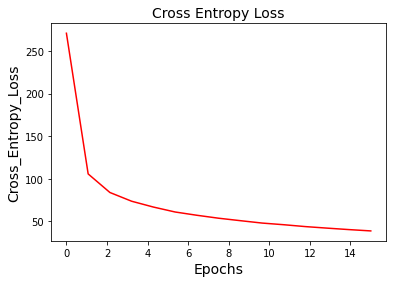

In [ ]:
import matplotlib.pyplot as plt # ej 画的loss


x = torch.linspace(0,15,15)
# print(loss)
# plt.plot(x,loss[0],c='r')
plt.plot(x,loss_mse,c='r')

plt.title('Cross Entropy Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Cross_Entropy_Loss',fontsize=14)


In [ ]:
layer = model.fc3.state_dict()
print(layer['weight'].shape)
# print(layer['bias'])
# print(np.array(b1_tmp).shape)
# print(np.array(b1_tmp[1]))
# print(np.array(f3_tmp).shape)
# print(np.array(f3_tmp[20]))
# a  = np.array(f3_tmp[1])
# b  = np.array(f3_tmp[100])
# np.array_equal(a,b)

torch.Size([10, 15])


In [ ]:
# print(np.array(f1_tmp).shape)
# print(np.array(f1_tmp).shape)
scipy.io.savemat('FC1.mat', {'FC1': f1_tmp})
scipy.io.savemat('FC2.mat', {'FC2': f2_tmp})
scipy.io.savemat('FC3.mat', {'FC3': f3_tmp})
scipy.io.savemat('FC4.mat', {'FC4': f4_tmp})
scipy.io.savemat('b1.mat', {'B1': b1_tmp})
scipy.io.savemat('b2.mat', {'B2': b2_tmp})
scipy.io.savemat('b3.mat', {'B3': b3_tmp})
scipy.io.savemat('b4.mat', {'B4': b4_tmp})
# scipy.io.savemat('test.mat', {'FC1': f1_tmp})

In [ ]:
# print(np.array(f1_tmp).shape)
# print(np.array(f1_tmp[4266]))
# scipy.io.savemat('FC2.mat', {'FC2': f2_tmp})

(4690, 10, 784)
[[-0.03377093 -0.00504475  0.01581838 ...  0.00904136  0.0259698
  -0.03515424]
 [-0.00992687 -0.02652802 -0.01304659 ...  0.02239924 -0.02326629
   0.02559799]
 [-0.00912324  0.00201515 -0.02117907 ...  0.03380657  0.01222465
   0.035463  ]
 ...
 [-0.01989166 -0.03122515 -0.02524178 ... -0.01304739 -0.01243589
  -0.00077624]
 [-0.02392267  0.03128301  0.03566968 ...  0.01202069 -0.02305736
   0.02444376]
 [ 0.01972819 -0.02840354 -0.00592689 ...  0.00345186  0.02009589
   0.03302803]]


(4690, 10, 784)
[[-0.01908846 -0.00535276 -0.02092243 ... -0.02273466 -0.01031135
  -0.00423497]
 [-0.01075637 -0.01572868 -0.00961933 ... -0.01968317 -0.01926269
   0.00614829]
 [ 0.01738293  0.01869999  0.0356869  ... -0.0299047  -0.00977882
   0.03546996]
 ...
 [ 0.00898107 -0.03377498  0.02263777 ...  0.03295657  0.01710314
  -0.01144409]
 [ 0.02688853 -0.00144087  0.00321078 ...  0.02152635  0.03433807
   0.0023303 ]
 [ 0.03233566 -0.03430497 -0.02689921 ... -0.00212233 -0.03531493
  -0.01151305]]

In [ ]:
model.eval()

# Compute the model accuracy on the test set
correct = 0# scipy.io.savemat('test.mat', {'FC1': f1_tmp})
total = 0

# YOUR CODE HERE
for (images, labels) in testloader:
  # print(labels.shape)
  out = model(images)         #out[128,10] 输出128个图片 对应10个标签的可能性大小) 
  # print('out:',out.shape)        #out: torch.Size([128, 10]) 最后一个out: torch.Size([16, 10])
  total += labels.shape[0]        #labels.shape[0] = 128 * n
  for i in range(out.shape[0]):     #一个epoc=128 分了n个epoch
    A,prediction = out[i].max(0)    #每一个epoch 输出最大的那个值
    # print('A:',A)           #A: tensor(1.0000, grad_fn=<MaxBackward0>) A: tensor(0.9986, grad_fn=<MaxBackward0>)
    # print('prediction:',prediction)  #prediction: tensor(9)
    if prediction == labels[i]:
      correct +=1
print('Test Accuracy: %2.2f %%' % ((100.0 * correct) / total))

Test Accuracy: 92.73 %


__In multi-class classification tasks it is often instructive to explore the accuracy of each class. Use the code block below to complete the function that produces the per-class accuracy:__

In [ ]:
# Compute the model accuracy on the test set
class_correct = torch.zeros(10)
class_total = torch.zeros(10)

for (images, labels) in testloader:

  for label in labels:
    class_total[label] += 1 #统计label的总数 label: tensor(4) label: tensor(2)
  
  outputs = model(images)
  for i in range(outputs.shape[0]):
    _, prediction = outputs[i].max(0) #_，p_close是因为那个函数是有两个返回值的，如果只给一个参数去接受就变成了返回一个list 如果不需要用到变量_，这样用起来舒服点而已
    if prediction == labels[i]:
      class_correct[labels[i]] += 1

for i in range(10):
    print('Class %d accuracy: %2.2f %%' % (i, 100.0*class_correct[i] / class_total[i]))

Class 0 accuracy: 96.33 %
Class 1 accuracy: 97.89 %
Class 2 accuracy: 90.99 %
Class 3 accuracy: 90.99 %
Class 4 accuracy: 94.81 %
Class 5 accuracy: 85.09 %
Class 6 accuracy: 96.56 %
Class 7 accuracy: 92.12 %
Class 8 accuracy: 88.19 %
Class 9 accuracy: 93.06 %
